recon, mu, logvar = vae(input)

In [1]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
from torch.utils.data import DataLoader
from gan_synthesis.datasets.dataset import Dataset
from torch import unique
dataset = Dataset()
loader = DataLoader(dataset, batch_size=369)

classes = 0
frequencies = {0: 0, 1: 0, 2: 0, 3: 0}
for _, seg in loader:
    uniques, counts = unique(seg, return_counts=True)
    print(counts)

weights = 1 / counts + 4e-6
class_weights = weights / weights.sum()

percents = counts / counts.sum()
print(percents)

tensor([2458239,  246423,  486903,  209139])
tensor([0.7229, 0.0725, 0.1432, 0.0615])


In [ ]:
import math
from dataclasses import dataclass
from pathlib import Path
from typing import Tuple, Dict

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

from gan_synthesis.datasets.dataset import Dataset
from gan_synthesis.mask_vae_models.vae import VAE, dice_loss_mc_opts, kl_divergence_capacity

@dataclass
class TrainConfig:
    seed: int = 42
    epochs: int = 200
    batch_size: int = 16
    lr: float = 1e-4
    weight_decay: float = 1e-4
    num_workers: int = 4
    pin_memory: bool = True
    amp: bool = True  
    ckpt_dir: str = "checkpoints"                                                                   
    val_split: float = 0.05
    latent_dim: int = 128
    lr_patience: int = 10  # ReduceLROnPlateau patience
    lr_factor: float = 0.5
    min_lr: float = 1e-5


def set_seed(seed: int):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # comment out for speed if you don't need strict determinism
    # torch.use_deterministic_algorithms(True)
    # torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


def accuracy_from_logits(logits: torch.Tensor, targets: torch.Tensor) -> float:
    """Pixel accuracy for segmentation."""
    pred = logits.argmax(dim=1)
    correct = (pred == targets).sum().item()
    total = targets.numel()
    return correct / total

def build(cfg: TrainConfig):
    """Construct everything needed for training/eval, no side-effects."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # --- Data ---
    dataset = Dataset()
    train_set, val_set = dataset.split(1 - cfg.val_split)

    common_loader_kwargs = dict(
        batch_size=cfg.batch_size,
        num_workers=cfg.num_workers,
        pin_memory=cfg.pin_memory,
        persistent_workers=cfg.num_workers > 0,
    )
    train_loader = DataLoader(train_set, shuffle=True,  **common_loader_kwargs)
    val_loader   = DataLoader(val_set,   shuffle=False, **common_loader_kwargs)

    # --- Model / Loss / Optimizer / Scheduler / Scaler ---
    model = VAE(latent_dim=cfg.latent_dim).to(device)

    class_weights = getattr(dataset, "weights", None)
    if class_weights is not None:
        class_weights = class_weights.to(device=device, dtype=torch.float32)
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    optimizer = optim.Adam(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode="min",
        factor=cfg.lr_factor,
        patience=cfg.lr_patience,
        min_lr=cfg.min_lr,
    )
    scaler = torch.amp.GradScaler("cuda") if (cfg.amp and device.type == "cuda") else None

    return {
        "device":       device,
        "model":        model,
        "criterion":    criterion,
        "optimizer":    optimizer,
        "scheduler":    scheduler,
        "scaler":       scaler,
        "train_set":    train_set,
        "val_set":      val_set,
        "train_loader": train_loader,
        "val_loader":   val_loader,
    }


def train_one_epoch(
    model: nn.Module,
    loader: DataLoader,
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    scaler: torch.amp.GradScaler | None,
    device: torch.device,
    current_epoch: int
) -> Dict[str, float]:
    model.train()
    running_loss = 0.0
    running_acc = 0.0    

    pbar = tqdm(loader, desc="Train", leave=False)
    for _, seg in pbar:
        seg_input = seg.to(torch.float32).to(device)
        seg_target = seg.squeeze(1).long().to(device)

        optimizer.zero_grad(set_to_none=True)

        if scaler is not None:
            with torch.amp.autocast(device_type=device.type, enabled=(scaler is not None)):
                recon, mu, logvar = model(seg_input)
                kld_loss = kl_divergence_capacity(mu, logvar, epoch=current_epoch, beta=1, max_capacity=50)
                ce_loss = criterion(recon, seg_target)
                dice_loss = dice_loss_mc_opts(recon, seg_target, ignore_bg=True)
                loss = ce_loss + 0.5 * dice_loss + kld_loss

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            recon, mu, logvar = model(seg_input)
            kld_loss = kl_divergence_capacity(mu, logvar, epoch=current_epoch, beta=1, max_capacity=50)
            ce_loss = criterion(recon, seg_target)
            dice_loss = dice_loss_mc_opts(recon, seg_target, ignore_bg=True)
            loss = ce_loss + 0.5 * dice_loss + kld_loss
            loss.backward()
            optimizer.step()

        acc = accuracy_from_logits(recon.detach(), seg_target)
        running_loss += loss.item()
        running_acc += acc
        pbar.set_postfix({"loss": f"{loss.item():.4f}", "acc": f"{acc:.4f}"})

    n = len(loader)
    return {"loss": running_loss / n, "acc": running_acc / n}


@torch.no_grad()
def evaluate(
    model: nn.Module,
    loader: DataLoader,
    criterion: nn.Module,
    device: torch.device,
    current_epoch: int
) -> Dict[str, float]:
    model.eval()
    running_loss = 0.0
    running_acc = 0.0

    # inference_mode
    with torch.inference_mode():
        pbar = tqdm(loader, desc="Val", leave=False)
        for _, seg in pbar:
            seg_input = seg.to(torch.float32).to(device, non_blocking=True)
            seg_target = seg.squeeze(1).long().to(device, non_blocking=True)
            recon, mu, logvar = model(seg_input)

            kld_loss = kl_divergence_capacity(mu, logvar, epoch=current_epoch, beta=1, max_capacity=50)
            ce_loss = criterion(recon, seg_target)
            dice_loss = dice_loss_mc_opts(recon, seg_target, ignore_bg=True)
            loss = ce_loss + 0.5 * dice_loss + kld_loss

            acc = accuracy_from_logits(recon, seg_target)

            running_loss += loss.item()
            running_acc += acc
            pbar.set_postfix({"loss": f"{loss.item():.4f}", "acc": f"{acc:.4f}"})

    n = len(loader)
    return {"loss": running_loss / n, "acc": running_acc / n}


def main(cfg: TrainConfig) -> Tuple[nn.Module, Dict]:
    set_seed(cfg.seed)
    parts = build(cfg)

    device       = parts["device"]
    model        = parts["model"]
    criterion    = parts["criterion"]
    optimizer    = parts["optimizer"]
    scheduler    = parts["scheduler"]
    scaler       = parts["scaler"]
    train_loader = parts["train_loader"]
    val_loader   = parts["val_loader"]

    # --- Bookkeeping ---
    Path(cfg.ckpt_dir).mkdir(parents=True, exist_ok=True)
    best_val = math.inf
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    writer = SummaryWriter(log_dir=str(Path("runs") / "exp1"))  # <<< add

    for epoch in range(cfg.epochs):
        print(f"\nEpoch {epoch+1}/{cfg.epochs}")

        train_metrics = train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, current_epoch=epoch)
        val_metrics   = evaluate(model, val_loader, criterion, device, current_epoch=epoch)

        scheduler.step(val_metrics["loss"])

        history["train_loss"].append(train_metrics["loss"])
        history["train_acc"].append(train_metrics["acc"])
        history["val_loss"].append(val_metrics["loss"])
        history["val_acc"].append(val_metrics["acc"])

        # <<< add: TensorBoard scalars >>>
        writer.add_scalars("Loss", {"train": train_metrics["loss"],
                                    "val":   val_metrics["loss"]}, epoch)

        writer.add_scalars("Accuracy", {"train": train_metrics["acc"],
                                        "val":   val_metrics["acc"]}, epoch)
        writer.flush()

        print(
            f"train: loss {train_metrics['loss']:.4f} | acc {train_metrics['acc']:.4f} "
            f"|| val: loss {val_metrics['loss']:.4f} | acc {val_metrics['acc']:.4f} "
            f"|| lr: {optimizer.param_groups[0]['lr']:.2e}"
        )

        # Save latest
        torch.save(
            {
                "epoch": epoch + 1,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "scaler_state": scaler.state_dict() if scaler is not None else None,
                "cfg": cfg.__dict__,
                "history": history,
            },
            Path(cfg.ckpt_dir) / "latest.pt",
        )

        # Save best on val loss
        if val_metrics["loss"] < best_val:
            best_val = val_metrics["loss"]
            torch.save(model.state_dict(), Path(cfg.ckpt_dir) / "best_model.pt")

    print("\nTraining complete.")
    writer.close()
    return model, history  # <-- return the trained model too

   

if __name__ == "__main__":
    cfg = TrainConfig()
    model, history = main(cfg)




Epoch 1/200


Train:   0%|          | 0/22 [00:00<?, ?it/s]c:\Users\zzmir\Documents\Projects\gan_synthesis\.pixi\envs\default\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


train: loss 2.0208 | acc 0.1410 || val: loss 1.9103 | acc 0.1852 || lr: 1.00e-04

Epoch 2/200


train: loss 1.9559 | acc 0.2503 || val: loss 1.8357 | acc 0.3838 || lr: 1.00e-04

Epoch 3/200


train: loss 1.8518 | acc 0.5029 || val: loss 1.7396 | acc 0.6189 || lr: 1.00e-04

Epoch 4/200


train: loss 1.8430 | acc 0.6527 || val: loss 1.9150 | acc 0.6870 || lr: 1.00e-04

Epoch 5/200


train: loss 1.7010 | acc 0.6914 || val: loss 1.6491 | acc 0.6974 || lr: 1.00e-04

Epoch 6/200


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from gan_synthesis.mask_vae_models.vae import VAE, dice_loss_mc_opts, kl_divergence_capacity, kl_divergence
from gan_synthesis.datasets.dataset import Dataset
from tqdm import tqdm

# Instantiate data loaders
dataset = Dataset()
train_set, test_set = dataset.split(0.95)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=True)

# Instantiate models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VAE(latent_dim=32).to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss(weight=dataset.weights.to(device))

# Before the loop
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
ce_losses = []

# final_z = torch.zeros(shape=)
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    running_kld_loss = 0.0
    running_ce_loss = 0.0
    running_dice_loss = 0.0

    # if epoch == 499:
    #     with torch.no_grad():
    #         recon, mu, logvar = model(seg_input)


    # if epoch % 10 == 0 and epoch != 0:
    #     with torch.no_grad:
    #         recon, mu, logvar = model

    for _, seg in tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False):
        correct, total = 0, 0
        seg_input = seg.to(torch.float32).to(device)
        seg_target = seg.squeeze(1).long().to(device)

        recon, mu, logvar = model(seg_input)
        # if epoch == 499:
        #     with torch.no_grad():
        # kld = kl_divergence(mu, logvar)
        # print(kld, kld.shape)
        kld_loss = kl_divergence_capacity(mu, logvar, epoch=epoch, beta=1, max_capacity=20)
        ce_loss = criterion(recon, seg_target)
        dice_loss = dice_loss_mc_opts(recon, seg_target, ignore_bg=True)
        loss = ce_loss + kld_loss + 0.5 * dice_loss

        pred = torch.argmax(recon, dim=1)
        correct += (pred == seg_target).sum().item()
        total += seg.numel()

        

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        running_kld_loss += kld_loss
        running_ce_loss += ce_loss
        running_dice_loss += dice_loss
        running_train_loss += loss.item()
    
    

    avg_train_loss = running_train_loss / len(train_loader)
    avg_kld_loss = running_kld_loss / len(train_loader)
    avg_ce_loss = running_ce_loss / len(train_loader)
    avg_dice_loss = running_dice_loss / len(train_loader)
    ce_losses.append(avg_ce_loss.item())
    train_losses.append(avg_train_loss)

    acc = correct / total
    train_accuracies.append(acc)

    # Validation
    model.eval()
    running_val_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for _, seg in tqdm(test_loader, desc="Test", leave=False):
            seg_input = seg.to(torch.float32).to(device)
            seg_target = seg.squeeze(1).long().to(device)
            recon, mu, logvar = model(seg_input)
            kld_loss = kl_divergence_capacity(mu, logvar, epoch=epoch, beta=1, max_capacity=50)
            ce_loss = criterion(recon, seg_target)
            dice_loss = dice_loss_mc_opts(recon, seg_target, ignore_bg=True)
            loss = ce_loss + 0.5 * dice_loss + kld_loss
            running_val_loss += loss.item()

            pred = torch.argmax(recon, dim=1)
            correct += (pred == seg_target).sum().item()
            total += seg.numel()

    avg_val_loss = running_val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    acc = correct / total
    val_accuracies.append(acc)

    # print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f}, KLD Train Loss: {avg_kld_loss:.4f}, CE Train Loss: {avg_ce_loss:.4f}, Dice Train Loss: {avg_dice_loss:.4f}\
    #         \nVal Loss: {avg_val_loss:.4f}, Val Acc: {acc:.4f}")


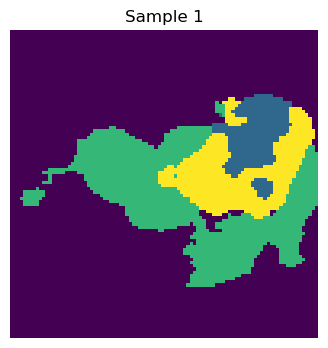

In [15]:
import matplotlib.pyplot as plt
image = model.sample(1, mode="argmax")


In [17]:
from random import randint
import numpy as np
import matplotlib.pyplot as plt
from gan_synthesis.preprocessing.transforms import read_cropped

def random_recon(model):
    num = randint(0, 368)
    image = read_cropped(idx=num, t="seg", as_type='pt').unsqueeze(0)
    seg_input = image.to(torch.float32).to("cuda")
    model.eval()
    with torch.no_grad():
        recon, mu, logvar = model(seg_input)
    
    recon = recon.argmax(dim=1)

    plt.imshow(image.squeeze().cpu().numpy())
    plt.show()
    plt.imshow(recon.squeeze().cpu().numpy())
    plt.show()
    

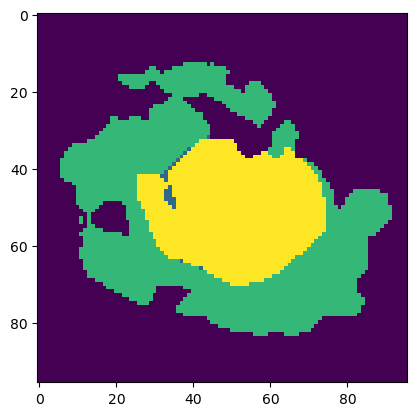

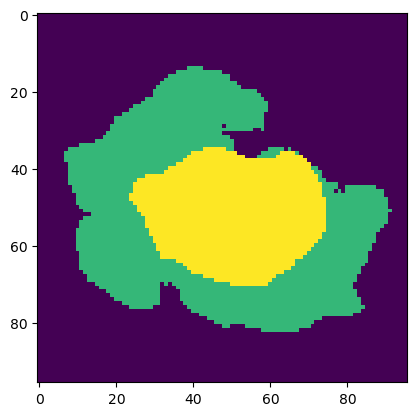

In [32]:
random_recon(model)

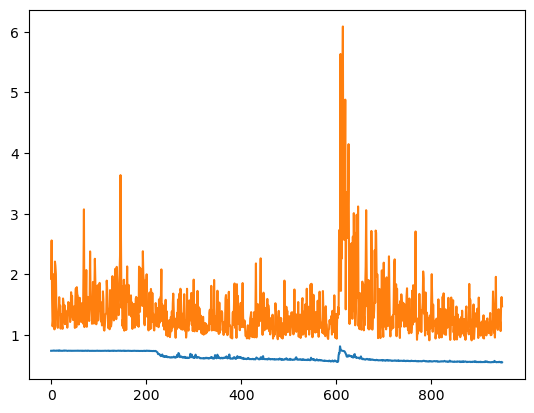

In [7]:
import matplotlib.pyplot as plt


plt.plot(ce_losses[50:])
plt.plot(val_losses[50:])
plt.show()

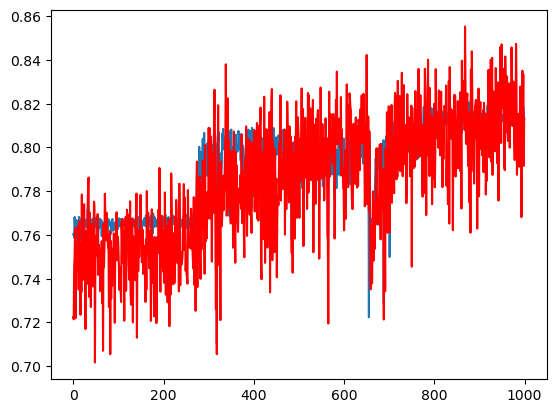

In [5]:
plt.plot(val_accuracies)
plt.plot(train_accuracies, 'r')
plt.show()